## Active Learning

Активное обучение $-$ класс алгоритмов обучения моделей машинного обучения. Алгоритмы активного обучения отличаются тем, могут интерактивно запрашивать пользователя (или некоторый другой источник информации) для разметки новых примеров данных.

<img src="active_learning.png">

## Active Learning Strategies

#### Pool-Based Sampling

В этом сценарии экземпляры извлекаются из всего пула данных и им присваивается информативная оценка, которая показывает, насколько хорошо текущий алгоритм «понимает» данные. 

Затем система выбираются и размечаются наиболее информативные примеры.

#### Uncertainty sampling


В рамках этого алгоритма размечаются те примеры, на которых текущая модель наименее уверена.

В качестве функций "уверенности" можно использовать вероятности классов или расстояния до разделяющей гиперплоскости.

#### Membership Query Synthesis

Здесь алгритм обучения модели генерирует свои собственные примеры из некоторого настраиваемого распределения. 
Эти сгенерированные примеры отправляются на разметку и модель дообучается с учетом разметки этих примеров.

#### Query by Committee

Идея: построить ансамбль моделей $a_1,...,a_T$. 

Выбирать новые объекты $x_i$ с наибольшей несогласованностью решений ансамбля моделей.



Принцип максимума энтропии: выбираем $x_i$, на котором $a_t(x_i)$ максимально различны.

Принцип максимума средней $KL$-дивергенции:выбираем $x_i$ , на котором $P_t(y|x_i)$ максимально различны:

$С(y|u) = \frac{1}{T}\sum_{t=1}^T P_t(y|u)$ - консенсус комитета 

## SVM для Active Learning

Некоторые активные алгоритмы обучения построены на алгоритме SVM и используют структуру SVM для определения того, какие точки данных нужно размечать. 

SVM используется для определения уверенности модели в предсказании на каждом из примеров выборки. 
В качестве меры уверенности служит расстояние от объекта до построенной не текущей итерации разделяющей гиперплоскости.

## Active Learning for texts classification

Рассмотрим алгоритм pool-based active learning на примере задачи классификации твитов по тональности.


1. Разделить данные на X_pool (выборка, которую можно размечать) и X_test.
2. Выбрать $k$ примеров из X_pool для начального X_train и разметить их. Остальные данные в X_pool $-$ валидационное множество. 
3. Обучить модель на  X_train.
5. Сделать predict обученной моделью на X_pool, вычислить вероятности для каждого $x_i$.
6. Вычислить качество работы модели на X_test.
7. Выбрать $k$ наиболее информативных объектов из X_pool, основываясь на уверенности модели в каждом из объектов (например, вероятности классов).
8. Переменести эти $k$ выбранных объектов в X_train.
9. Если качество работы модели на X_test достаточное, то останавливаемся, иначе возвращаемся к шагу 3.

In [60]:
from sklearn.metrics import f1_score

In [61]:
import pandas as pd
import numpy as np
from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from nltk import ngrams

from sklearn.linear_model import LogisticRegression 
from sklearn.feature_extraction.text import CountVectorizer

In [62]:
# positive = pd.read_csv('positive.csv', sep=';', usecols=[3], names=['text'])
# positive['label'] = ['positive'] * len(positive)
# negative = pd.read_csv('negative.csv', sep=';', usecols=[3], names=['text'])
# negative['label'] = ['negative'] * len(negative)
# df = positive.append(negative)

In [63]:
df = pd.read_csv('spam_text_classification_data.csv')
print(df.shape)
df.head()

(5572, 2)


,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [64]:
df['label'] = [0 if category == 'ham' else 1 for category in df['Category']]

In [65]:
def get_confidence(class_probs):
    return abs(0.5-class_probs[0])

In [66]:
train_size = 50

dataset_size = X.shape[0]
target_score = 0.95
score = 0
step = 10

X_train = X[:train_size]
y_train = y[:train_size]
X_pool = X[train_size:]
y_pool = y[train_size:]

scores = [0]
train_szs = [0]

while score < target_score and train_size <= dataset_size:
    vec = CountVectorizer(ngram_range=(1, 1))
    bow = vec.fit_transform(X_train)
    clf = clf.fit(bow,y_train)
    pred = clf.predict(vec.transform(X_test))
    
    print("{0} train samples".format(train_size))
    print(classification_report(pred, y_test))
    score = f1_score(pred, y_test)
    scores.append(score)
    train_szs.append(train_size)
    
    pred_probs = clf.predict_proba(vec.transform(X_pool))
    confidences = [get_confidence(probs) for probs in pred_probs]
    
    X_train = np.concatenate([X_train, X_pool[np.argsort(confidences)[:step]]])
    y_train = np.concatenate([y_train, y_pool[np.argsort(confidences)[:step]]])
    X_pool = X_pool[sorted(np.argsort(confidences)[step:])]
    y_pool = y_pool[sorted(np.argsort(confidences)[step:])]
    train_size += step

50 train samples
              precision    recall  f1-score   support

           0       1.00      0.91      0.95      1072
           1       0.30      0.98      0.45        43

   micro avg       0.91      0.91      0.91      1115
   macro avg       0.65      0.94      0.70      1115
weighted avg       0.97      0.91      0.93      1115

60 train samples
              precision    recall  f1-score   support

           0       0.99      0.93      0.96      1037
           1       0.49      0.90      0.64        78

   micro avg       0.93      0.93      0.93      1115
   macro avg       0.74      0.91      0.80      1115
weighted avg       0.96      0.93      0.94      1115

70 train samples
              precision    recall  f1-score   support

           0       0.99      0.95      0.97      1012
           1       0.65      0.90      0.76       103

   micro avg       0.95      0.95      0.95      1115
   macro avg       0.82      0.93      0.86      1115
weighted avg       0.96

In [67]:
vec = CountVectorizer(ngram_range=(1, 1))
bow = vec.fit_transform(X)
clf = clf.fit(bow,y)
pred = clf.predict(vec.transform(X_test))

print("{0} train samples".format(dataset_size))
print(classification_report(pred, y_test))

4457 train samples
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       986
           1       0.91      1.00      0.95       129

   micro avg       0.99      0.99      0.99      1115
   macro avg       0.95      0.99      0.97      1115
weighted avg       0.99      0.99      0.99      1115



In [68]:
from matplotlib import pyplot as plt

%matplotlib inline

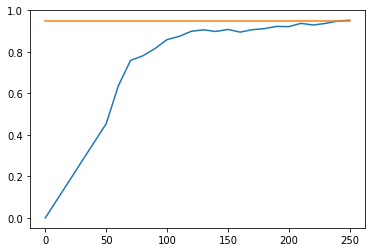

In [69]:
plt.plot(train_szs,scores)
plt.plot(train_szs, [0.95 for sz in train_szs])

Можно видеть, что для достижения лучшего качества на этом датасете дсотаточно обучиться на 300 правильно выбранных примерах.